<a href="https://colab.research.google.com/github/DasBlaueWunder/Homeworx/blob/main/Homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7

## Fashion-MNIST with Autoencoder

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def show_examples(dataset, number):
  for i,(image, label) in enumerate(dataset.take(number)):
    title = "Example " + str(i) + ": Shape = "+ str(image.shape) + ", Label = " + str(label.numpy())
    plt.figure()
    image = np.asarray(image)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.title(title)
    plt.show()

### 1. Load data set and preprocess

Load the data set and explore.
The Fashion MNIST dataset consists of 60000 28x28 grayscale images in 10 classes. There are 50000 training images and 10000 test images.

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYYVTO6/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYYVTO6/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


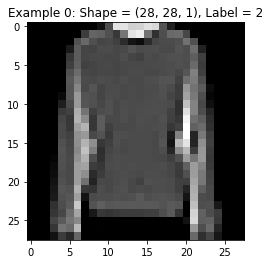

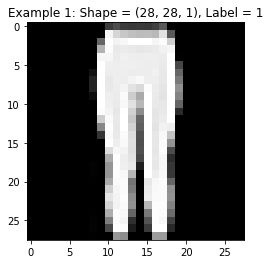

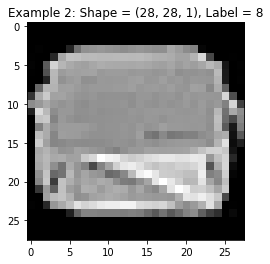

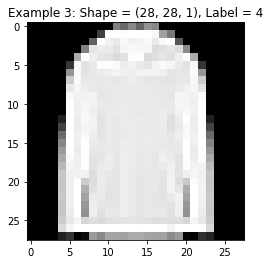

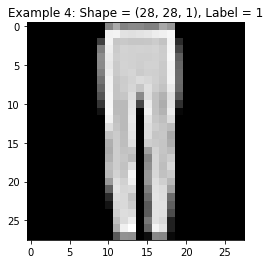

In [ ]:
# Load train and test data set as shuffled subsets of the cifar10 data set
train_dataset, test_dataset = tfds.load('fashion_mnist', as_supervised=True, split = ['train', 'test'], shuffle_files = True)
assert isinstance(train_dataset, tf.data.Dataset)

# Show some examples
show_examples(train_dataset, 5)

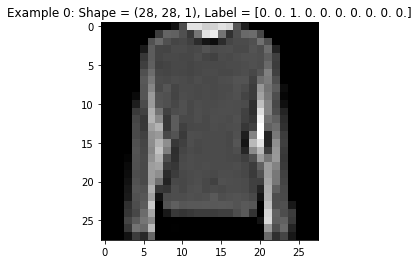

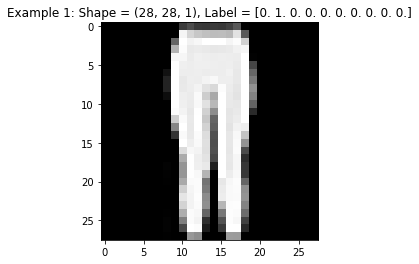

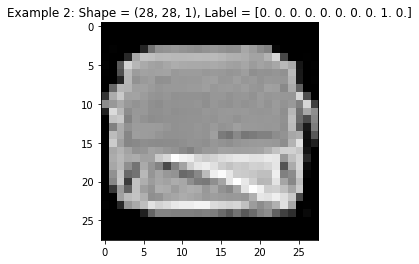

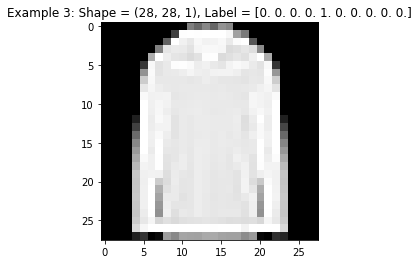

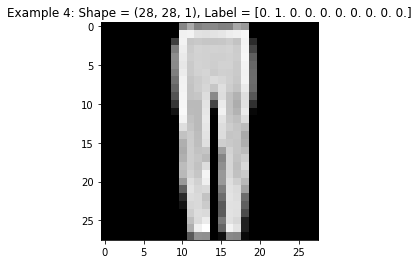

In [ ]:
# Normalize the input
def preprocess(dataset):
  dataset = dataset.map(lambda image, label: (image/255,tf.one_hot(label,10))) # one-hot, since normal labels are not iterable
  return dataset

train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

# Show some examples (just to control, if everything has been done correctly)
show_examples(train_dataset, 5)

# Batching and fetching
# Another shuffle (buffer_size should be greater equal data set size)
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(128).prefetch(1)
test_dataset = test_dataset.shuffle(buffer_size=60000).batch(128).prefetch(1)

## Autoencoder

An Autoencoder is made of an encoder (with #{output neurons} << #{input size}) and a decoder (with output size = input size), which compares, if the input can be reconstructed by the decoder.

Since each image has size 28x28 with 28=2*2*7, we have to be careful in the Pooling Layer, so that by upsampling we are able to retrieve an output of the same size as our input.


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__(name='')
    self.conv1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same')
    self.pool1 = tf.keras.layers.MaxPooling2D(2)
    self.conv2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')
    self.pool2 = tf.keras.layers.MaxPooling2D(2)
    self.conv3 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same') # 7x7x8 = 392 output size
    self.flatt = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(64, activation='relu')

  def call(self, x, training=False):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.flatt(x)
    x = self.dense(x)
    return x


class Decoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__(name='')
    self.dense = tf.keras.layers.Dense(392, activation='relu')
    self.reshape = tf.keras.layers.Reshape([7,7,8])
    self.conv1 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')
    self.up2 = tf.keras.layers.UpSampling2D()
    self.conv2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')
    self.up3 = tf.keras.layers.UpSampling2D()
    self.conv3 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same')
    self.conv4 = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, activation = 'sigmoid', padding = 'same')

  def call(self, x, training=False):
    x = self.dense(x)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.up2(x)
    x = self.conv2(x)
    x = self.up3(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return x



In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, x, training):
        # Define the forward step.
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

Train with Adam for 30 epochs with a learning rate of 0.001, while the loss is the MSE over all pixels.

In [ ]:
def train_step(model, input, loss_function, optimizer, training = True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(input, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function, training = False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, _) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(input, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize the model.
model = Model()
# Initialize the loss for binary classification
loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

#testing once before we begin
test_loss = test(model, test_dataset, loss)
test_losses.append(test_loss)

#check how model performs on train data once before we begin
train_loss = test(model, train_dataset, loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=1000)
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    #training (and checking in with training)
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, loss, optimizer)
    train_losses.append(train_loss)

    #testing
    test_loss = test(model, test_dataset, loss)
    test_losses.append(test_loss)

    # Show accuracy
    print('Current loss: ' + str(test_loss))

Epoch: 0
Current loss: 0.020182583
Epoch: 1
Current loss: 0.016997518
Epoch: 2
Current loss: 0.015787406
Epoch: 3
Current loss: 0.01510434
Epoch: 4
Current loss: 0.015296481
Epoch: 5
Current loss: 0.014094535
Epoch: 6
Current loss: 0.013550277
Epoch: 7
Current loss: 0.013554252
Epoch: 8
Current loss: 0.013279326
Epoch: 9
Current loss: 0.013504279
Epoch: 10
Current loss: 0.013444587
Epoch: 11
Current loss: 0.013260277
Epoch: 12
Current loss: 0.012765788
Epoch: 13
Current loss: 0.012482161
Epoch: 14
Current loss: 0.012768392
Epoch: 15
Current loss: 0.01253029
Epoch: 16
Current loss: 0.0131251
Epoch: 17
Current loss: 0.012351615
Epoch: 18
Current loss: 0.012840388
Epoch: 19
Current loss: 0.012527958
Epoch: 20
Current loss: 0.012259445
Epoch: 21
Current loss: 0.01230456
Epoch: 22
Current loss: 0.012105617
Epoch: 23
Current loss: 0.011956031
Epoch: 24
Current loss: 0.014143944
Epoch: 25
Current loss: 0.012042973
Epoch: 26
Current loss: 0.0118289385
Epoch: 27
Current loss: 0.01186404
Epoch: 

### Visualization


In [ ]:
%matplotlib inline

# Loss (in one plot)
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

Latent space analysis


In [ ]:
from sklearn.manifold import TSNE

# Yet to be implemented

### Interpolation between original and network output (same weight)

In [ ]:
ds = train_dataset.take(5)

for (input, _) in ds:
    plt.figure()
    original = np.asarray(input)
    plt.imshow(image, cmap='gray')

    image = model(input, False)
    image = np.asarray(image[0,:,:,0])
    image = (original + image)/2
    plt.imshow(image, cmap='gray')
    plt.show()